# üìÑ Hoja de Trabajo 2
Integrantes
- Diego Alexander Hern√°ndez Silvestre - 21270
- Mario Antonio Guerra Morales - 21008
- Linda In√©s Jim√©nez Vides 21169

## üíª Ejercicio 1
### Preparaci√≥n del conjunto de datos üìà

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar el conjunto de datos de Iris
iris = load_iris()
X = iris.data  # Caracter√≠sticas
y = iris.target  # Etiquetas

df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Dividir el conjunto de datos en entrenamiento y validaci√≥n
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Mostrar los tama√±os de los conjuntos resultantes
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de validaci√≥n: {X_test.shape[0]} muestras")
df_iris.head()


Conjunto de entrenamiento: 105 muestras
Conjunto de validaci√≥n: 45 muestras


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

### üß† Arquitectura del modelo

In [3]:
# Red neuronal feedforward
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Capa de entrada
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Capa oculta
        self.fc3 = nn.Linear(hidden_size2, output_size)  # Capa de salida

        self.relu = nn.ReLU()  # Funci√≥n de activaci√≥n ReLU
        self.softmax = nn.Softmax(dim=1)  # Funci√≥n de activaci√≥n Softmax para la capa de salida

    def forward(self, x):
        # Pasar los datos a trav√©s de la red
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Par√°metros de la red
input_size = 4  # N√∫mero de caracter√≠sticas de entrada
hidden_size1 = 10  # N√∫mero de neuronas en la primera capa oculta
hidden_size2 = 8  # N√∫mero de neuronas en la segunda capa oculta
output_size = 3  # N√∫mero de clases de salida

# Instancia de la red neuronal
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Mostrar la estructura de la red
print(model)


SimpleFeedforwardNN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


### üìâ Funciones de perdida

In [4]:
# Verificar si CUDA est√° disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
def loss_functions():
    # Definir las funciones de p√©rdida a comparar
    loss_functions = [
        ('CrossEntropy', nn.CrossEntropyLoss()),
        ('MSE', nn.MSELoss()),
        ('NLL', nn.NLLLoss())
    ]

    results = []

    # Iterar sobre cada funci√≥n de p√©rdida
    for loss_name, criterion in loss_functions:
        # Inicializar el modelo y el optimizador
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_losses = []
        test_losses = []

        # Entrenamiento durante 100 √©pocas
        for epoch in range(100):
            model.train()  # Poner el modelo en modo entrenamiento
            outputs = model(X_train_tensor.to(device))  # Hacer una pasada hacia adelante

            # Calcular la p√©rdida seg√∫n la funci√≥n de p√©rdida
            if loss_name == 'CrossEntropy':
                loss = criterion(outputs, y_train_tensor.to(device))
            elif loss_name == 'NLL':
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_train_tensor.to(device))
            else:
                # 'MSE' usa etiquetas one-hot
                loss = criterion(outputs, nn.functional.one_hot(y_train_tensor, num_classes=output_size).float().to(device))

            # Actualizar los gradientes
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # Evaluar el modelo
            model.eval()  # Poner el modelo en modo evaluaci√≥n
            with torch.no_grad():
                test_outputs = model(X_test_tensor.to(device))  # Hacer una pasada hacia adelante en el conjunto de prueba

                # Calcular la p√©rdida en el conjunto de prueba
                if loss_name == 'CrossEntropy':
                    test_loss = criterion(test_outputs, y_test_tensor.to(device))
                elif loss_name == 'NLL':
                    log_probs = nn.functional.log_softmax(test_outputs, dim=1)
                    test_loss = criterion(log_probs, y_test_tensor.to(device))
                else:
                    # 'MSE' usa etiquetas one-hot
                    test_loss = criterion(test_outputs, nn.functional.one_hot(y_test_tensor, num_classes=output_size).float().to(device))

                test_losses.append(test_loss.item())

        # Calcular la precisi√≥n
        model.eval()  # Poner el modelo en modo evaluaci√≥n
        with torch.no_grad():
            test_outputs = model(X_test_tensor.to(device))
            _, predicted = torch.max(test_outputs.data, 1)  # Obtener las predicciones de clase
            accuracy = (predicted == y_test_tensor.to(device)).sum().item() / y_test_tensor.size(0)  # Calcular la precisi√≥n

        # Almacenar los resultados
        results.append((loss_name, train_losses[-1], test_losses[-1], accuracy))

    # Imprimir los resultados
    for loss_name, train_loss, test_loss, accuracy in results:
        print(f"Loss Function: {loss_name}")
        print(f"Final Training Loss: {train_loss:.4f}")
        print(f"Final Test Loss: {test_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print()

loss_functions()

Loss Function: CrossEntropy
Final Training Loss: 0.5827
Final Test Loss: 0.5621
Accuracy: 1.0000

Loss Function: MSE
Final Training Loss: 0.0119
Final Test Loss: 0.0030
Accuracy: 1.0000

Loss Function: NLL
Final Training Loss: 0.6106
Final Test Loss: 0.5915
Accuracy: 0.9556



### üìä T√©cnicas de Regularizaci√≥n

In [7]:
def regularization():
    # Tipos de regularizaci√≥n a evaluar
    reg_types = ['None', 'L1', 'L2', 'Dropout']
    results = []

    # Iterar sobre cada tipo de regularizaci√≥n
    for reg_type in reg_types:
        # Inicializar el modelo para cada tipo de regularizaci√≥n
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)

        # Aplicar la regularizaci√≥n seg√∫n el tipo
        if reg_type == 'Dropout':
            model.fc1 = nn.Sequential(
                model.fc1,
                nn.Dropout(0.5)  # Aplicar Dropout con probabilidad del 50%
            )
            model.fc2 = nn.Sequential(
                model.fc2,
                nn.Dropout(0.5)  # Aplicar Dropout con probabilidad del 50%
            )

        # Definir la funci√≥n de p√©rdida y el optimizador
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        # Entrenamiento durante 100 √©pocas
        for epoch in range(100):
            model.train()  # Poner el modelo en modo entrenamiento
            outputs = model(X_train_tensor.to(device))  # Hacer una pasada hacia adelante

            # Calcular la p√©rdida
            loss = criterion(outputs, y_train_tensor.to(device))

            # Aplicar regularizaci√≥n L1 o L2 si corresponde
            if reg_type == 'L1':
                l1_lambda = 0.01  # Hiperpar√°metro de regularizaci√≥n L1
                l1_norm = sum(p.abs().sum() for p in model.parameters())  # Calcular la norma L1
                loss = loss + l1_lambda * l1_norm  # Agregar la regularizaci√≥n L1 a la p√©rdida
            elif reg_type == 'L2':
                l2_lambda = 0.01  # Hiperpar√°metro de regularizaci√≥n L2
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # Calcular la norma L2
                loss = loss + l2_lambda * l2_norm  # Agregar la regularizaci√≥n L2 a la p√©rdida

            # Actualizar los gradientes
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluar el modelo
        model.eval()  # Poner el modelo en modo evaluaci√≥n
        with torch.no_grad():
            test_outputs = model(X_test_tensor.to(device))  # Hacer una pasada hacia adelante en el conjunto de prueba
            _, predicted = torch.max(test_outputs.data, 1)  # Obtener las predicciones de clase
            accuracy = (predicted == y_test_tensor.to(device)).sum().item() / y_test_tensor.size(0)  # Calcular la precisi√≥n
            test_loss = criterion(test_outputs, y_test_tensor.to(device))  # Calcular la p√©rdida en el conjunto de prueba

        # Almacenar los resultados
        results.append((reg_type, test_loss.item(), accuracy))

    # Imprimir los resultados para cada tipo de regularizaci√≥n
    for reg_type, test_loss, accuracy in results:
        print(f"Regularization: {reg_type}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print()

regularization()

Regularization: None
Test Loss: 0.5653
Accuracy: 1.0000

Regularization: L1
Test Loss: 0.7311
Accuracy: 0.8000

Regularization: L2
Test Loss: 0.6071
Accuracy: 0.9778

Regularization: Dropout
Test Loss: 0.6467
Accuracy: 0.9333



### üìà Algoritmos de Optimizaci√≥n

In [9]:
# Funci√≥n para entrenar el modelo con distintas t√©cnicas de optimizaci√≥n
def train_with_optimizers(optimizer_name):
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'BatchGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'MiniBatchGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validaci√≥n
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, test_losses, train_accuracies, test_accuracies, training_time

In [10]:
# Ejecutar t√©cnicas de optimizaci√≥n con distintos algoritmos.
optimizers = ['SGD', 'BatchGD', 'MiniBatchGD']
results = {}

for optimizer in optimizers:
    train_loss, test_loss, train_acc, test_acc, time_taken = train_with_optimizers(optimizer)
    results[optimizer] = {
        'train_loss': train_loss, 'test_loss': test_loss,
        'train_acc': train_acc, 'test_acc': test_acc,
        'time': time_taken
    }
    print(f"{optimizer} completed in {time_taken:.2f} seconds")

SGD completed in 1.37 seconds
BatchGD completed in 1.27 seconds
MiniBatchGD completed in 1.28 seconds


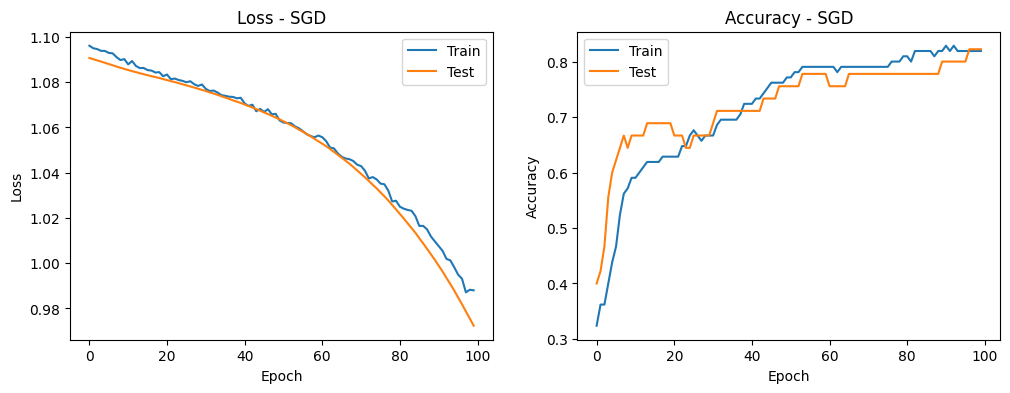

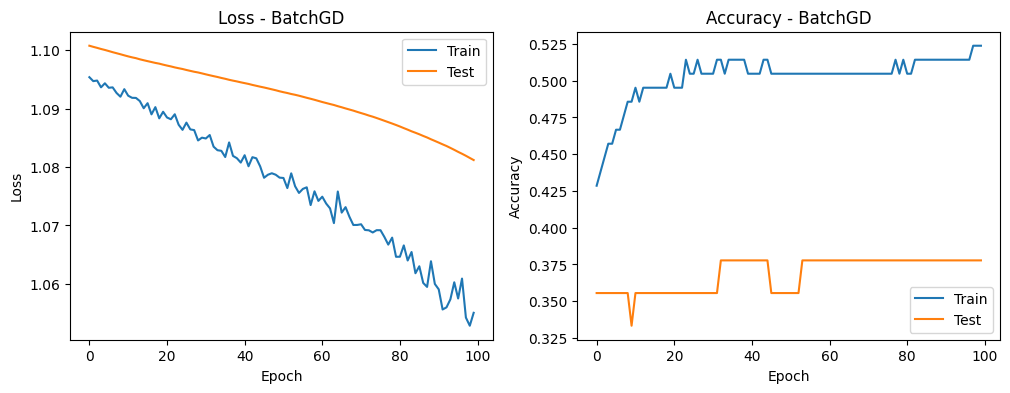

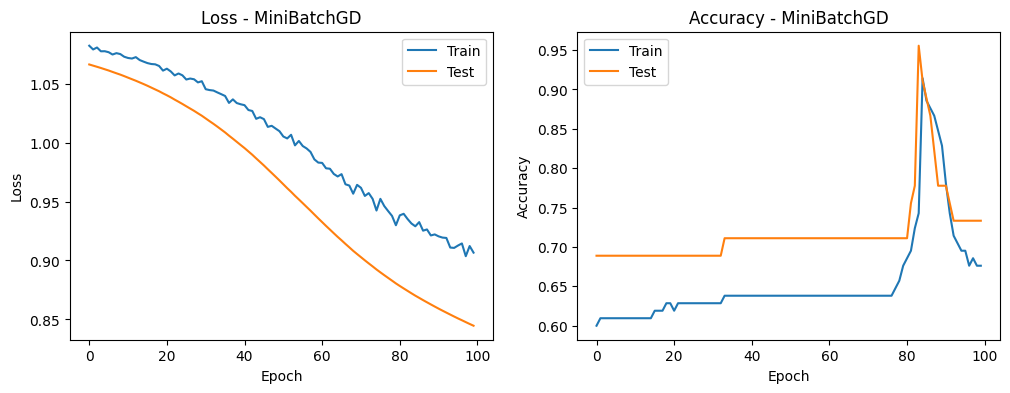

In [11]:
# Gr√°ficos
for optimizer, result in results.items():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(result['train_loss'], label='Train')
    plt.plot(result['test_loss'], label='Test')
    plt.title(f'Loss - {optimizer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['train_acc'], label='Train')
    plt.plot(result['test_acc'], label='Test')
    plt.title(f'Accuracy - {optimizer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### üß™ Experimentaci√≥n y An√°lisis

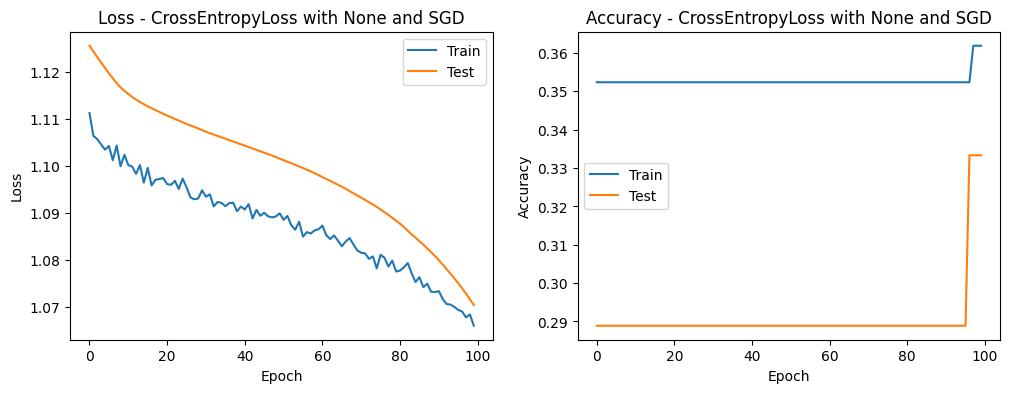

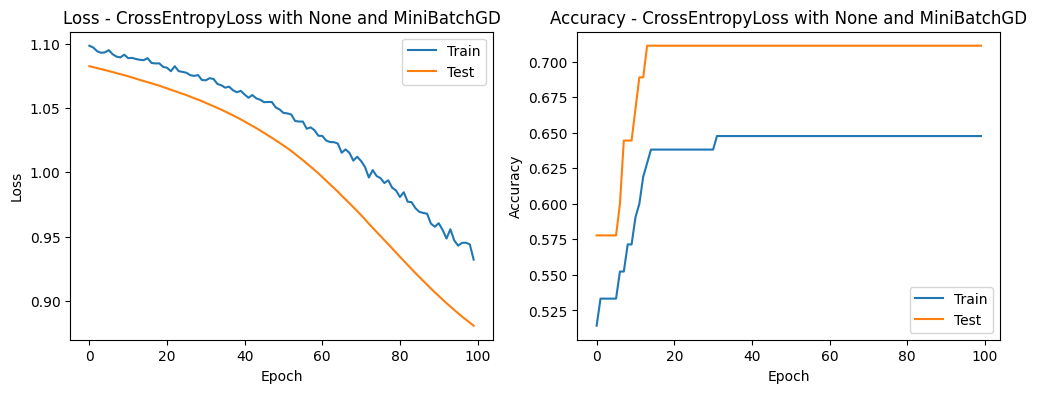

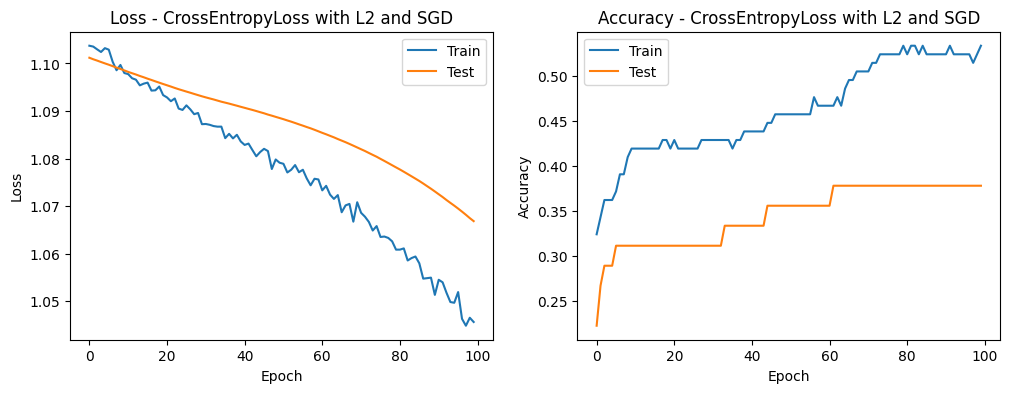

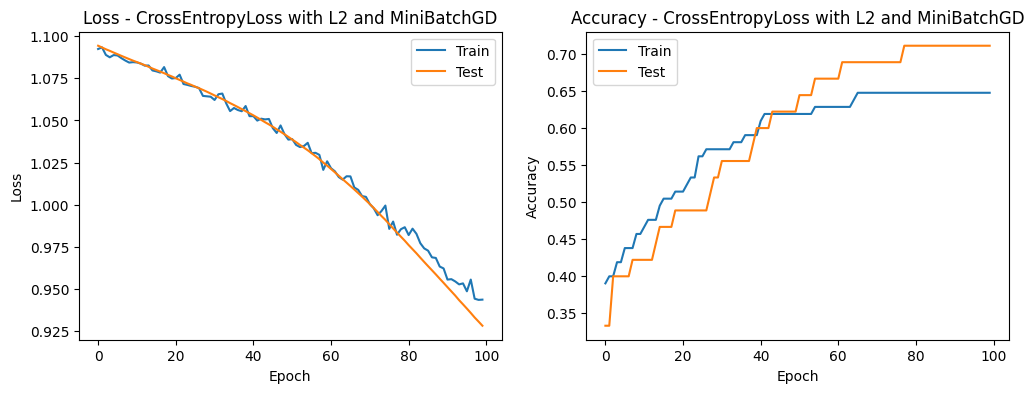

In [13]:
def experiment_combinations():
    # Definir combinaciones para entrenamiento.
    loss_functions = [nn.CrossEntropyLoss()]
    regularizations = ['None', 'L2']
    optimizers = ['SGD', 'MiniBatchGD']

    combinations = []
    for loss in loss_functions:
        for reg in regularizations:
            for opt in optimizers:
                combinations.append((loss, reg, opt))

    results = []

    for loss_fn, reg, optimizer_name in combinations:
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)

        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01)
        elif optimizer_name == 'MiniBatchGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01)

        if reg == 'L2':
            optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        start_time = time.time()

        for epoch in range(100):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracies.append(correct / total)

            # Validaci√≥n
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(test_loader))
            test_accuracies.append(correct / total)

        end_time = time.time()
        training_time = end_time - start_time

        results.append({
            'loss_fn': loss_fn.__class__.__name__,
            'regularization': reg,
            'optimizer': optimizer_name,
            'train_loss': train_losses,
            'test_loss': test_losses,
            'train_acc': train_accuracies,
            'test_acc': test_accuracies,
            'time': training_time
        })

    # Graficar los resultados obtenidos.
    for result in results:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(result['train_loss'], label='Train')
        plt.plot(result['test_loss'], label='Test')
        plt.title(f"Loss - {result['loss_fn']} with {result['regularization']} and {result['optimizer']}")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(result['train_acc'], label='Train')
        plt.plot(result['test_acc'], label='Test')
        plt.title(f"Accuracy - {result['loss_fn']} with {result['regularization']} and {result['optimizer']}")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
        print("\n")

experiment_combinations()

### üó£Ô∏è Discusi√≥n

Task 7

## üìö Ejercicio 2 - Attention Is All You Need

1. **¬øCu√°l es la principal innovaci√≥n de la arquitectura Transformer?**

La arquitectura transformer posee como principal innovaci√≥n ser el primer modelo que maneja secuencias de datos basado en su totalidad en Attention, con tal de poder procesar los elementos de la secuencia simult√°neamente, gracias a la Multi-Headed Self-Attention.

2. **¬øC√≥mo funciona el mecanismo de atenci√≥n del scaled dot-product?**

Consiste en queries, keys y values de distintas dimensiones. Se realiza un producto punto entre los queries y keys, posteriormente se divide este producto punto entre los valores de la dimensi√≥n de la key en cuesti√≥n. Al obtener los resultados, se aplica sobre ellos la funci√≥n softmax para obtener los pesos de los values.

3. **¬øPor qu√© se utiliza la atenci√≥n de m√∫ltiples cabezales en Transformer?**
4. **¬øC√≥mo se incorporan los positional encodings en el modelo Transformer?**
5. **¬øCu√°les son algunas aplicaciones de la arquitectura Transformer m√°s all√° de la machine translation?**